### MET triple modality autoencoder

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from functools import reduce
from cplAE_MET.utils.load_config import load_config
import cplAE_MET.utils.analysis_helpers as proc_utils


In [3]:
pca_th = 0.9 

In [4]:
def set_paths(config_file=None):
    paths = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['arbor_density_file'] = f'{paths["input"]}/{str(paths["arbor_density_file"])}'
    paths['arbor_density_PC_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_file"])}'
    paths['arbor_density_PC_vars_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_vars_file"])}'
    paths['ivscc_inhib_RawFeatureWide'] = f'{paths["input"]}/{str(paths["ivscc_inhib_RawFeatureWide"])}'
    paths['ivscc_exc_RawFeatureWide'] = f'{paths["input"]}/{str(paths["ivscc_exc_RawFeatureWide"])}'
    paths['fmost_exc_RawFeatureWide'] = f'{paths["input"]}/{str(paths["fmost_exc_RawFeatureWide"])}'


    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'

    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'

    return paths


In [5]:
dir_pth = set_paths(config_file='config_preproc.toml')

...................................................
There are 8643 sample_ids in the locked dataset
...................................................
Loading M arbor_densities
Number of cells in arbor density file: 8643
...................................................
0 cells do not have arbor density data!
...................................................
keeping only ids that are inside specimen id list
In total remains this amount of cells: 8643
...................................................
masking each arbor density channel and putting each channel in one specific key of a dict
...................................................
create a 1d mask for each arbor density channel
...................................................
PCA analysis 


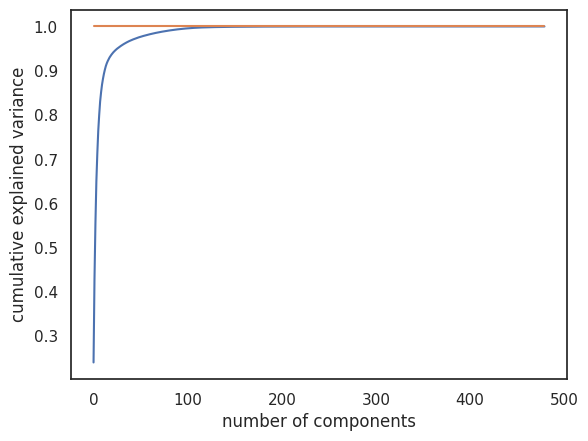

12


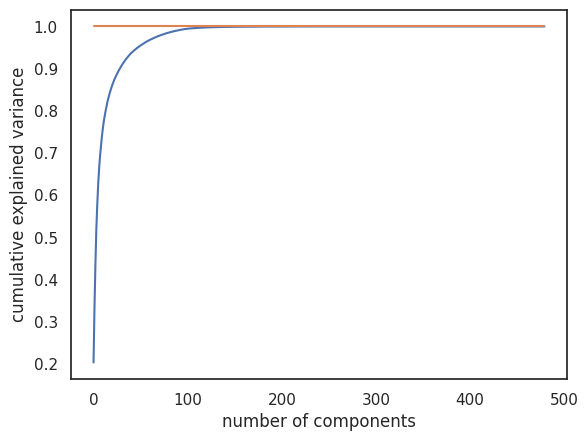

28


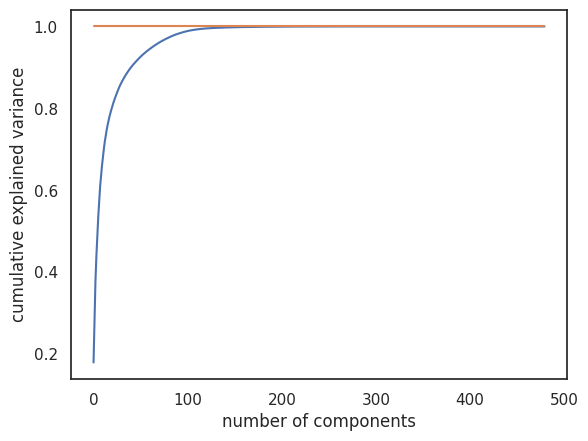

40


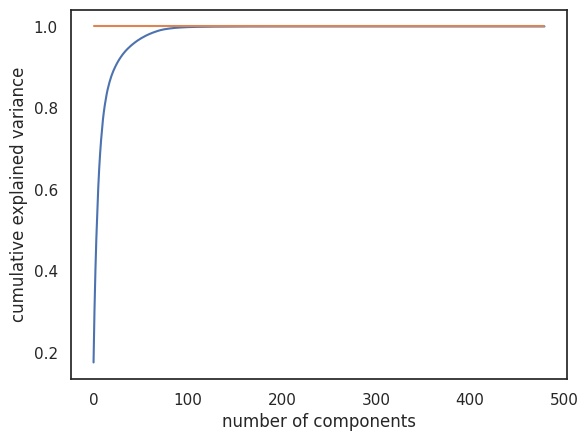

23
ax (971, 12)
de (971, 28)
api (1192, 40)
bas (1192, 23)
...................................................
Scaling PCA features


In [6]:
ids = pd.read_csv(dir_pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
print("...................................................")
print("There are", len(specimen_ids), "sample_ids in the locked dataset")


print("...................................................")
print("Loading M arbor_densities")
m_input = sio.loadmat(dir_pth['arbor_density_file'])


arbor_ids = [mystr.rstrip() for mystr in m_input['specimen_id']]
print("Number of cells in arbor density file:", len(arbor_ids))

print("...................................................")
print(len([i for i in specimen_ids if i not in arbor_ids]), "cells do not have arbor density data!")

print("...................................................")
print("keeping only ids that are inside specimen id list")
mask_arbor_ids = [True if i in specimen_ids else False for i in arbor_ids]
arbor_ids = [b for a, b in zip(mask_arbor_ids, arbor_ids) if a]
print("In total remains this amount of cells:", sum(mask_arbor_ids))

print("...................................................")
print("masking each arbor density channel and putting each channel in one specific key of a dict")
soma_depth = np.squeeze(m_input['soma_depth'])[mask_arbor_ids]
arbor_density = {}
arbor_density['ax'] = m_input['hist_ax_de_api_bas'][:,:,:,0][mask_arbor_ids]
arbor_density['de'] = m_input['hist_ax_de_api_bas'][:,:,:,1][mask_arbor_ids]
arbor_density['api'] = m_input['hist_ax_de_api_bas'][:,:,:,2][mask_arbor_ids]
arbor_density['bas'] = m_input['hist_ax_de_api_bas'][:,:,:,3][mask_arbor_ids]

print("...................................................")
print("create a 1d mask for each arbor density channel")
# in the arbor density file, if a cell does not have M data, all the channels are nan values
# if a cell is exc, the ax and de (first two channels) are all zeros and the api and bas (second 
# two channels) have values. This mask is to find the exc cells with M data and inh cells with M data. 
# so if all channels are nan, then it will return False. 

not_valid_xm_channels = np.apply_over_axes(np.all, 
                                            np.logical_or(m_input['hist_ax_de_api_bas'] == 0, 
                                            np.isnan(m_input['hist_ax_de_api_bas'])),
                                            axes = [1, 2])
not_valid_xm_channels = np.squeeze(not_valid_xm_channels)
valid={}
valid['ax'] = ~not_valid_xm_channels[:,0]
valid['de']= ~not_valid_xm_channels[:,1]
valid['api'] = ~not_valid_xm_channels[:,2]
valid['bas']= ~not_valid_xm_channels[:,3]

# Now for each channel, we mask for the valid cells and then we look if there is any
# nan value in the cells arbor densities. If there is any nan, we should either 
# remove that cell or put that nan to zero for that channel
keep_cells = {}
for k in arbor_density.keys():
    # mask for the cells with arbor density
    arbor_density[k] = arbor_density[k][valid[k]]
    # Find the m_cells with that have nan values in their non-OFF channels
    keep_cells[k] = ~np.squeeze(np.apply_over_axes(np.any, np.isnan(arbor_density[k]),axes = [1, 2]))
    # remove the cells that have nan values in each channel
    arbor_density[k] = arbor_density[k][keep_cells[k]]
    # collapse the last to dim and have a 1d arbor density for each channel
    arbor_density[k] = arbor_density[k].reshape(arbor_density[k].shape[0], -1)


print("...................................................")
print("PCA analysis ")
n_comp_at_thr={}
for k in arbor_density.keys():
    n_comp_at_thr[k] = proc_utils.get_PCA_explained_variance_ratio_at_thr(nparray=arbor_density[k], threshold=pca_th)
    if n_comp_at_thr[k] == 0:
        n_comp_at_thr[k] = 1
    # if n_comp_at_thr[k]> 20:
    #     n_comp_at_thr[k] = 20

    print(n_comp_at_thr[k])

PC = {}
for k in arbor_density.keys():
    if k != "ids":
        pca = PCA(n_comp_at_thr[k])
        # PC[k] = pca.fit_transform(arbor_density[k])[:, :20]
        PC[k] = pca.fit_transform(arbor_density[k])

        print(k, PC[k].shape)

print("...................................................")
print("Scaling PCA features")
#Scaling PC features
Scaled_PCs = {}
total_var = pd.DataFrame(columns=PC.keys())

for k in PC.keys():
    v = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / v
    total_var.loc[0, k] = v

# We save this cause we need them for the reconstruction of arbor densities
total_var.to_csv(dir_pth['arbor_density_PC_vars_file'], index=False)

...................................................
Removing outliers whithin 6 std from scaled PCs


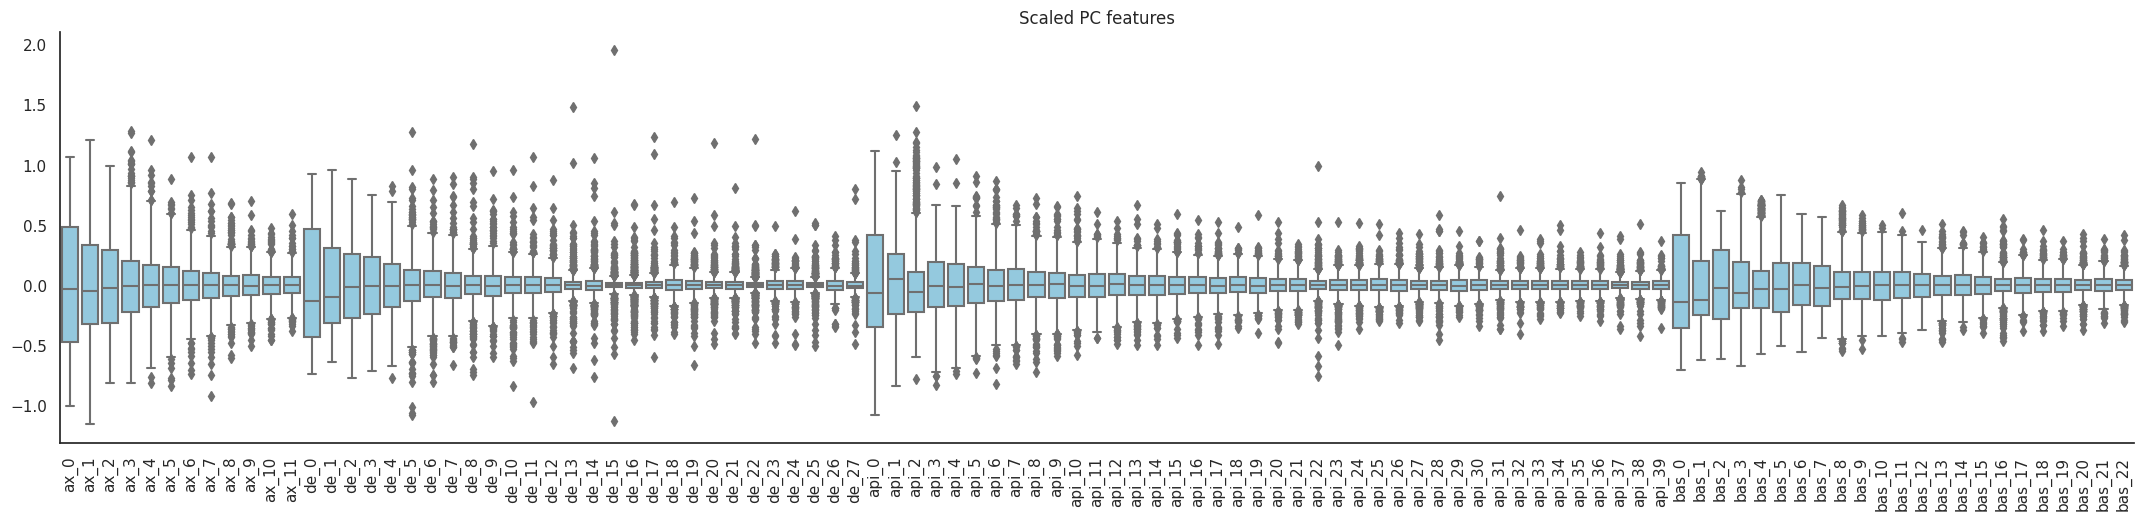

In [7]:
print("...................................................")
print("Removing outliers whithin 6 std from scaled PCs")
#attaching specimen ids and removing outliers
for k in PC.keys():
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])]
    valid_ids = [id for i, id in enumerate(arbor_ids) if valid[k][i]]
    valid_ids = [id for i, id in enumerate(valid_ids) if keep_cells[k][i]]
    Scaled_PCs[k]["specimen_id"] = valid_ids
    Scaled_PCs[k]['specimen_id'] = Scaled_PCs[k]['specimen_id'].astype(str)

#Merge all scaled PC features into one df
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])

Scaled_PCs = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)

df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled PC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [8]:
Scaled_PCs.head()

ax_0      ax_1      ax_2      ax_3      ax_4      ax_5      ax_6  \
0  0.372486 -0.870501  0.656789  0.559691  0.015270 -0.393066 -0.522451   
1  0.543691 -0.658797  0.400675  0.209574  0.035748 -0.087930  0.006088   
2  0.074588 -0.587531  0.479398  0.889335  0.696152  0.452523  0.418432   
3  0.315092 -0.814781  0.619308  0.594778  0.083412 -0.293300 -0.420015   
4  0.413268 -0.812997  0.558930  0.490170  0.161364 -0.086442 -0.016717   

       ax_7      ax_8      ax_9  ...  bas_13  bas_14 bas_15  bas_16  bas_17  \
0  0.615011  0.305466  0.207428  ...     NaN     NaN    NaN     NaN     NaN   
1  0.131846  0.102428  0.197217  ...     NaN     NaN    NaN     NaN     NaN   
2 -0.336880 -0.151069 -0.104850  ...     NaN     NaN    NaN     NaN     NaN   
3  0.486284  0.233602  0.106542  ...     NaN     NaN    NaN     NaN     NaN   
4  0.043493 -0.042935 -0.078563  ...     NaN     NaN    NaN     NaN     NaN   

   bas_18  bas_19  bas_20  bas_21  bas_22  
0     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN  

[5 rows x 104 columns]

In [9]:
# read M_metadata 
ivscc_inh = pd.read_csv(dir_pth['ivscc_inhib_RawFeatureWide'])
ivscc_exc = pd.read_csv(dir_pth['ivscc_exc_RawFeatureWide']) 
fmost_mf = pd.read_csv(dir_pth['fmost_exc_RawFeatureWide'])  

In [10]:
ivscc_inh.head()

specimen_id  axon_bias_x  axon_bias_y  axon_depth_pc_0  axon_depth_pc_1  \
0    601506507   180.833198  -249.830744       225.411533        23.731636   
1    601790961    25.481124   434.251083       207.739912      -140.825086   
2    601803754    42.650596   104.697843     -1285.848467      2978.406456   
3    601808698    42.200019   342.307240      -266.455827      -525.368215   
4    601810307    89.759903   239.040891     -1138.366992      -256.462577   

   axon_depth_pc_2  axon_depth_pc_3  axon_depth_pc_4  \
0      -288.048286      -208.877683      -439.450876   
1      -319.561459      -130.650796       216.915996   
2       238.978091       733.575398       472.375294   
3      -828.630775       952.648652      -242.285965   
4       845.477857      -582.400440        14.555271   

   axon_emd_with_basal_dendrite  axon_exit_distance  ...  \
0                     24.021389           21.366433  ...   
1                     40.815044           23.363826  ...   
2                     17.559571           15.924714  ...   
3                     11.139210            0.000000  ...   
4                     13.199471           28.647765  ...   

   basal_dendrite_mean_diameter  basal_dendrite_num_branches  \
0                      0.918386                         22.0   
1                      0.870701                         42.0   
2                      0.882682                         62.0   
3                      0.729696                         42.0   
4                      0.834698                         48.0   

   basal_dendrite_soma_percentile_x  basal_dendrite_soma_percentile_y  \
0                          0.137298                          0.522513   
1                          0.480986                          0.462676   
2                          0.460057                          0.333470   
3                          0.316378                          0.047513   
4                          0.454165                          0.198232   

   basal_dendrite_stem_exit_down  basal_dendrite_stem_exit_side  \
0                       0.000000                       0.500000   
1                       0.000000                       0.666667   
2                       0.125000                       0.625000   
3                       0.000000                       1.000000   
4                       0.333333                       0.666667   

   basal_dendrite_stem_exit_up  basal_dendrite_total_length  \
0                     0.500000                  2518.295630   
1                     0.333333                  4256.093901   
2                     0.250000                  4108.235412   
3                     0.000000                  2309.168299   
4                     0.000000                  3226.120636   

   basal_dendrite_total_surface_area  soma_aligned_dist_from_pia  
0                        7207.459813                  375.137103  
1                       11691.149209                  692.082653  
2                       11384.542643                  175.817839  
3                        5284.628374                  485.136930  
4                        8470.180595                  283.924764  

[5 rows x 46 columns]

### Inh cells features

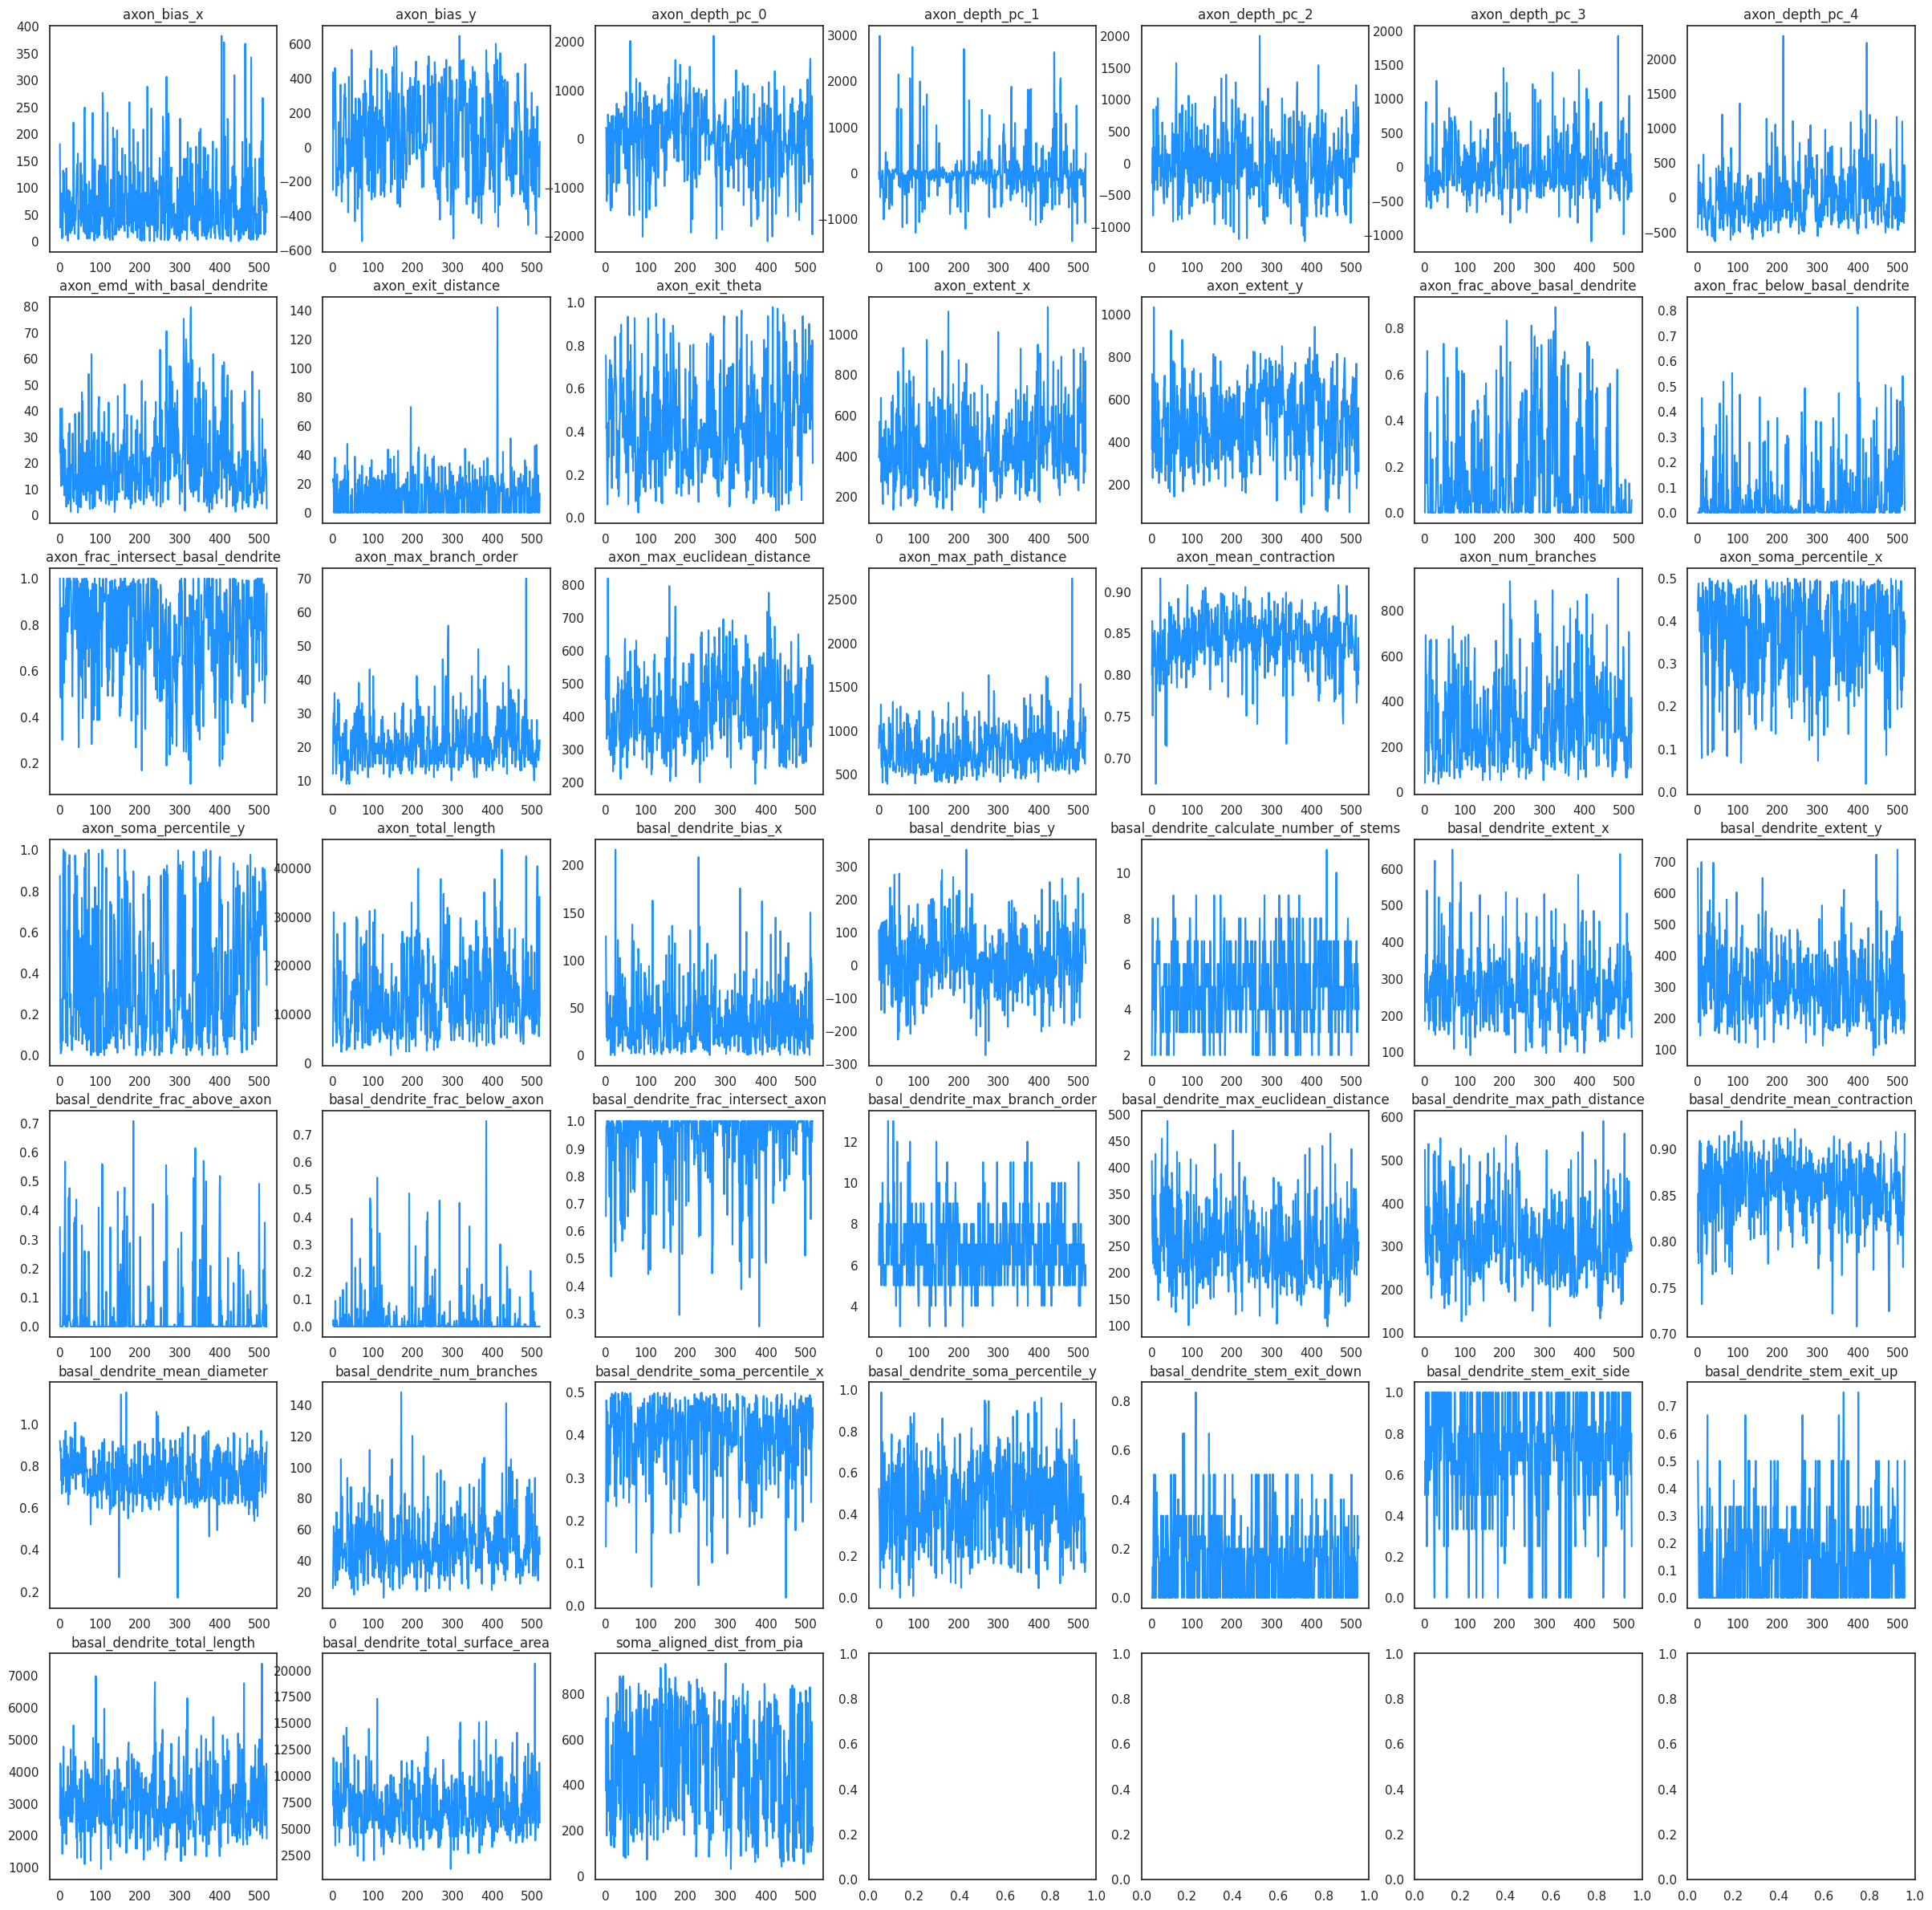

In [11]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in ivscc_inh.columns if i!="specimen_id"]):
    ax.plot(ivscc_inh[feature], color='dodgerblue')
    ax.set_title(feature)

### Exc cells features

In [12]:
ivscc_exc.head()

specimen_id  apical_dendrite_bias_x  apical_dendrite_bias_y  \
0    601628311              149.426303              389.131722   
1    603229579              116.869739              513.385750   
2    603481505              134.229429              424.155835   
3    603902877               94.534142              549.615328   
4    604098167               33.025512              542.700771   

   apical_dendrite_depth_pc_0  apical_dendrite_depth_pc_1  \
0                    7.011477                    6.333541   
1                  181.635311                  -56.664247   
2                  302.770040                  -35.430657   
3                  -16.626976                   33.994408   
4                  334.178889                   12.097656   

   apical_dendrite_depth_pc_2  apical_dendrite_depth_pc_3  \
0                   -5.148107                    6.613425   
1                   66.879525                   25.525516   
2                  122.511449                  -37.774279   
3                  -42.176107                  -35.693355   
4                   97.987245                  -21.523755   

   apical_dendrite_early_branch_path  apical_dendrite_emd_with_basal_dendrite  \
0                           0.377581                                67.020406   
1                           0.272368                                51.782594   
2                           0.370210                                47.265305   
3                           0.374798                                54.164126   
4                           0.283561                                55.288193   

   apical_dendrite_extent_x  ...  basal_dendrite_num_branches  \
0                306.920160  ...                         29.0   
1                322.217880  ...                         30.0   
2                355.251267  ...                         42.0   
3                153.023867  ...                         38.0   
4                347.359465  ...                         53.0   

   basal_dendrite_soma_percentile_x  basal_dendrite_soma_percentile_y  \
0                          0.210607                          0.855496   
1                          0.469305                          0.894992   
2                          0.394897                          0.839712   
3                          0.487805                          0.674390   
4                          0.376833                          0.913001   

   basal_dendrite_stem_exit_down  basal_dendrite_stem_exit_side  \
0                            0.0                       1.000000   
1                            0.0                       1.000000   
2                            0.0                       0.833333   
3                            0.0                       0.833333   
4                            0.0                       0.857143   

   basal_dendrite_stem_exit_up  basal_dendrite_total_length  \
0                     0.000000                  1842.712482   
1                     0.000000                  1559.948300   
2                     0.166667                  2744.146833   
3                     0.166667                  2781.788078   
4                     0.142857                  2659.837900   

   basal_dendrite_total_surface_area  soma_aligned_dist_from_pia  \
0                        4251.727723                  569.446408   
1                        3349.079209                  567.896643   
2                        7285.432249                  524.001658   
3                        9380.024438                  493.422741   
4                        7975.187084                  528.401997   

   soma_surface_area  
0         748.222915  
1         373.742932  
2         615.120965  
3        1110.101476  
4         775.036731  

[5 rows x 52 columns]

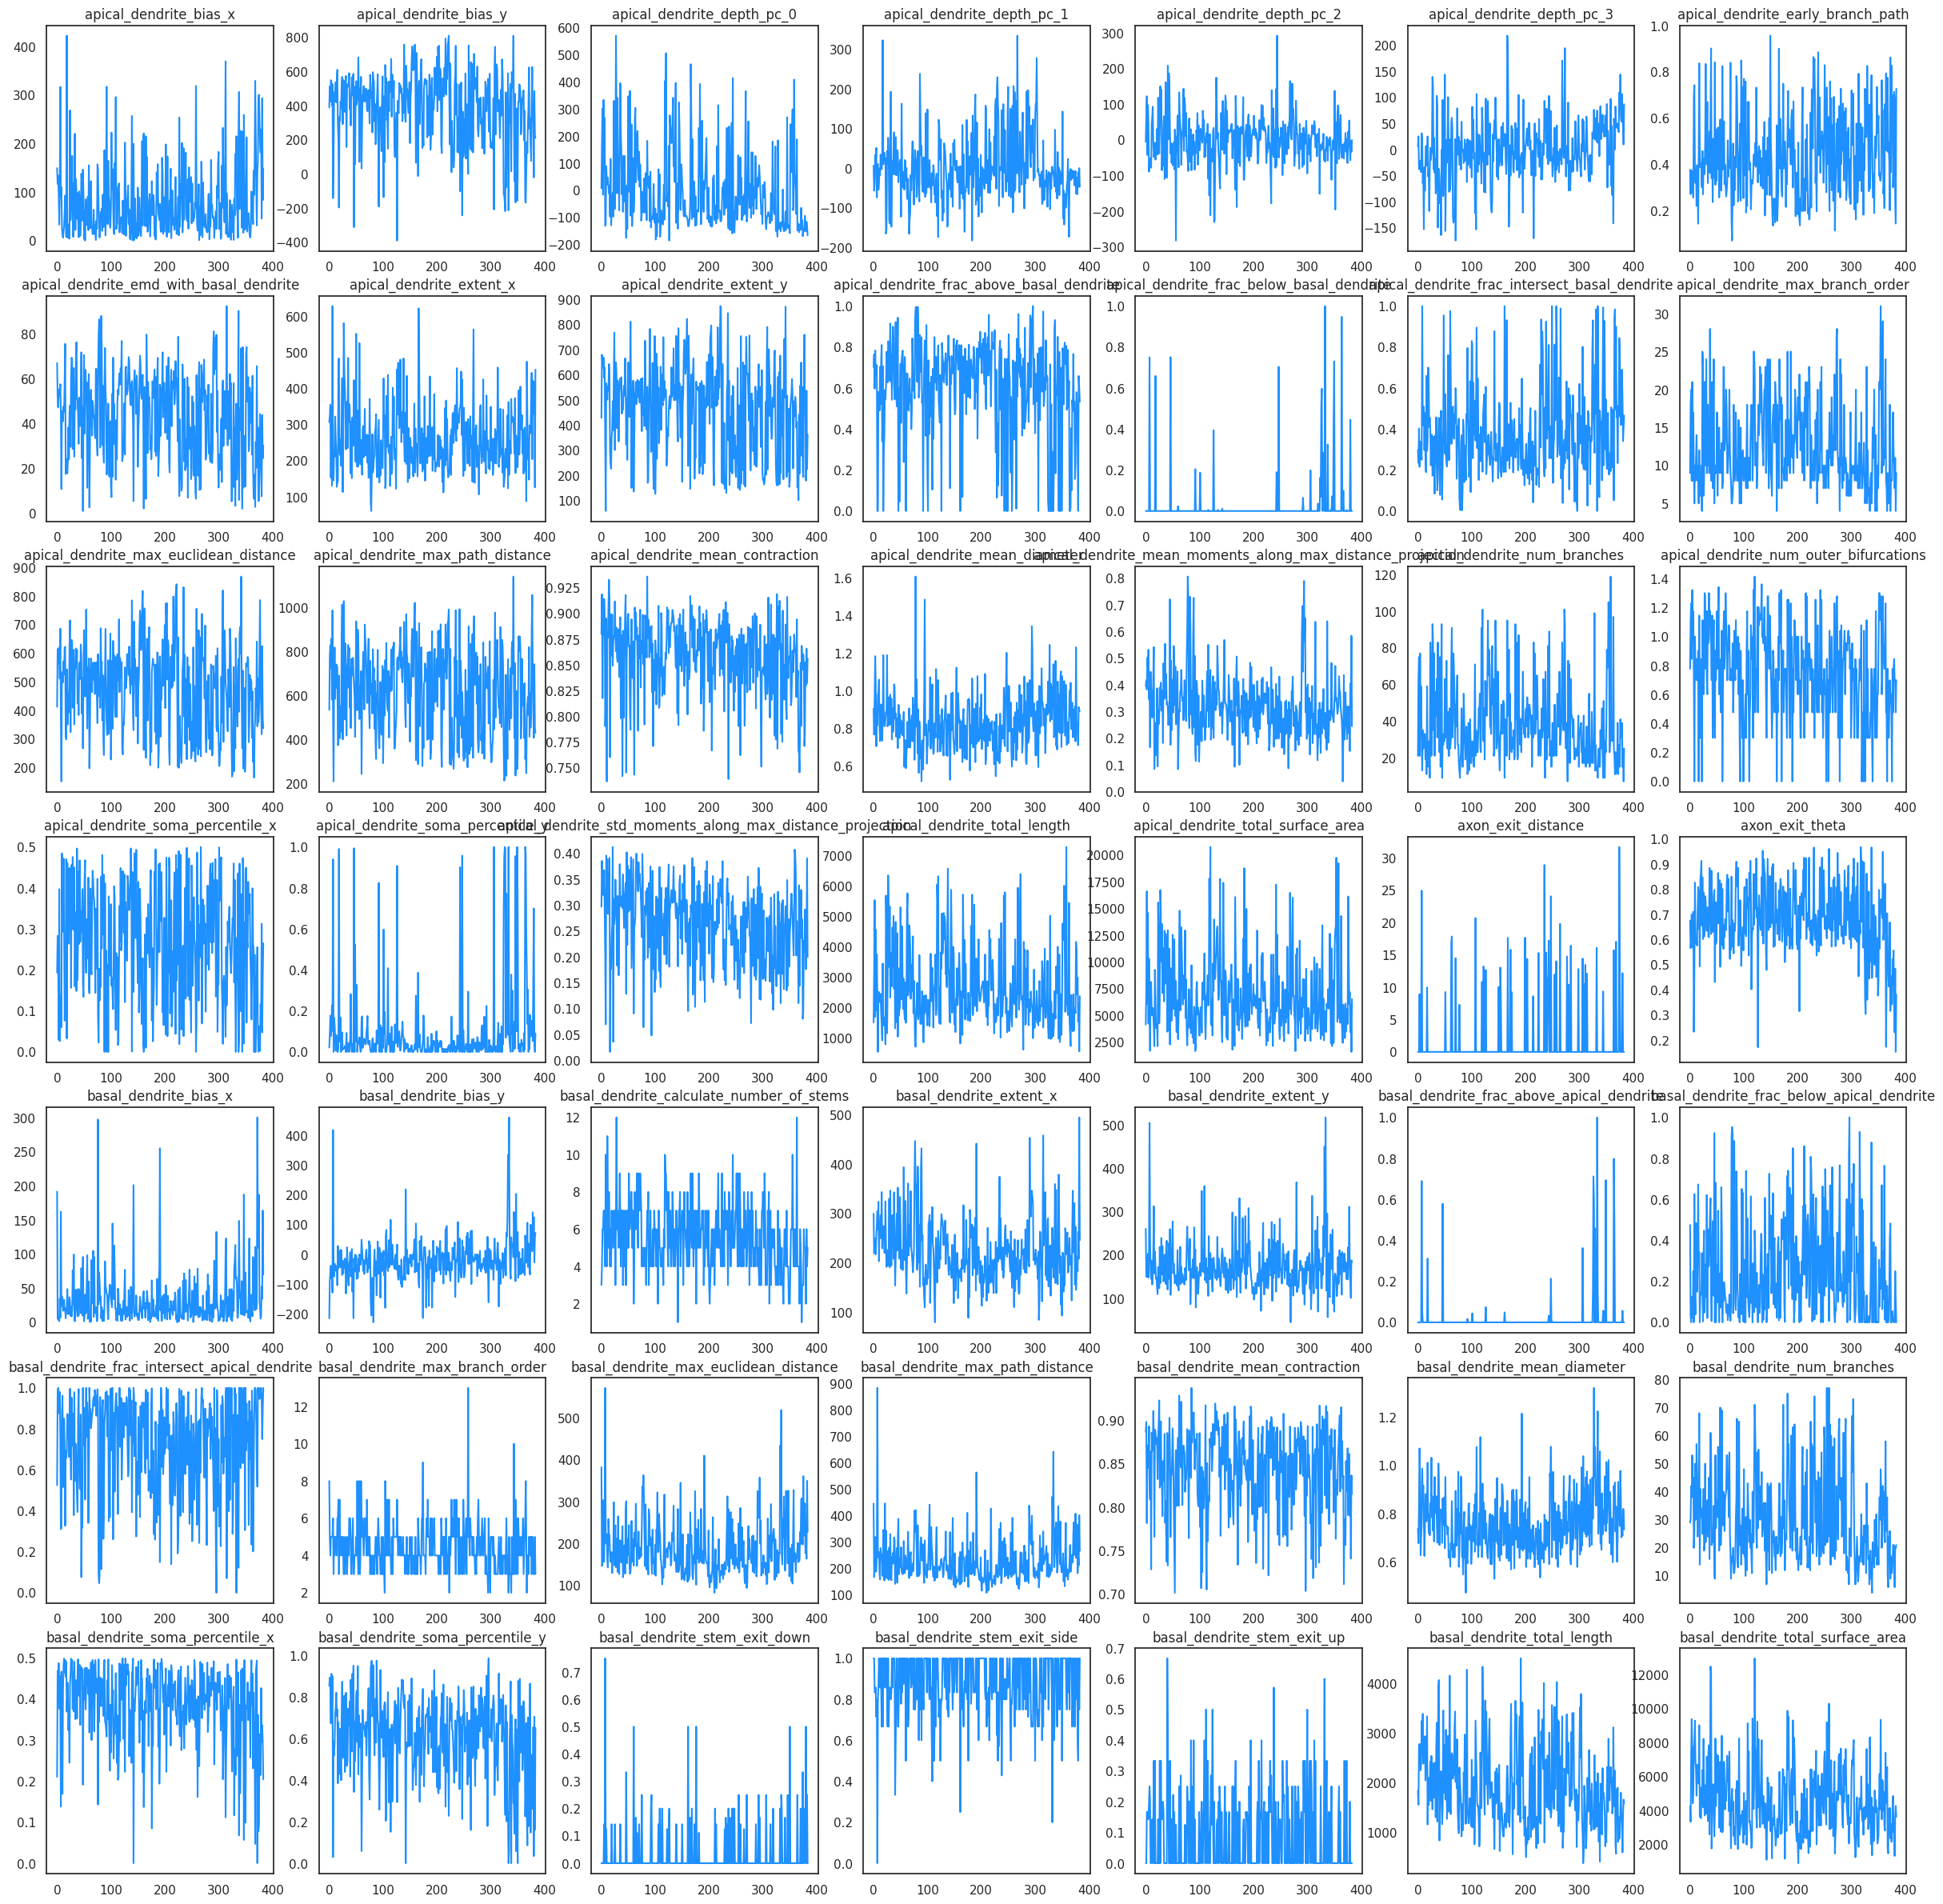

In [13]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in ivscc_exc.columns if i!="specimen_id"]):
    ax.plot(ivscc_exc[feature], color='dodgerblue')
    ax.set_title(feature)

### fMOST M features

In [14]:
fmost_mf.head()

Unnamed: 0                  specimen_id  apical_dendrite_bias_x  \
0           0   17109_6201-X4328-Y6753_reg                148.6700   
1           1  17109_6301-X4756-Y24516_reg                 83.5906   
2           2   17109_6601-X4384-Y7436_reg                     NaN   
3           3  17109_6601-X5417-Y25287_reg                 15.1209   
4           4   17109_6801-X7432-Y4405_reg                120.2471   

   apical_dendrite_bias_y  apical_dendrite_depth_pc_0  \
0                 35.7091                  -26.319656   
1                 25.7496                  -24.016929   
2                     NaN                    0.000000   
3               -154.7340                  -47.542648   
4               -197.5790                  -27.598021   

   apical_dendrite_depth_pc_1  apical_dendrite_depth_pc_2  \
0                  -26.521676                   16.411191   
1                  -23.520326                    9.768680   
2                    0.000000                    0.000000   
3                  -40.904532                   -1.891232   
4                  -32.906300                   31.485929   

   apical_dendrite_depth_pc_3  apical_dendrite_early_branch_path  \
0                   31.901829                           0.824205   
1                   34.725255                           0.484827   
2                    0.000000                                NaN   
3                   90.340870                           0.631446   
4                   29.624960                           0.415617   

   apical_dendrite_emd_with_basal_dendrite  ...  basal_dendrite_num_branches  \
0                                 7.794209  ...                         18.0   
1                                 4.484431  ...                         31.0   
2                              1963.000000  ...                         47.0   
3                                20.535911  ...                         34.0   
4                                12.975269  ...                         42.0   

   basal_dendrite_soma_percentile_x  basal_dendrite_soma_percentile_y  \
0                          0.059259                          0.344444   
1                          0.346226                          0.344340   
2                          0.366220                          0.473995   
3                          0.441919                          0.327020   
4                          0.443077                          0.555897   

   basal_dendrite_stem_exit_down  basal_dendrite_stem_exit_side  \
0                       0.500000                       0.500000   
1                       0.333333                       0.333333   
2                       0.333333                       0.333333   
3                       0.000000                       1.000000   
4                       0.000000                       0.750000   

   basal_dendrite_stem_exit_up  basal_dendrite_total_length  \
0                     0.000000                  1119.417870   
1                     0.333333                  1463.648621   
2                     0.333333                  2557.240216   
3                     0.000000                  2191.587034   
4                     0.250000                  2695.833164   

   basal_dendrite_total_surface_area  soma_aligned_dist_from_pia  \
0                        6983.667606                     777.531   
1                        9097.721238                     802.251   
2                       15087.851071                     749.577   
3                       13482.614995                     771.865   
4                       16810.061927                     637.755   

   soma_surface_area  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 53 columns]

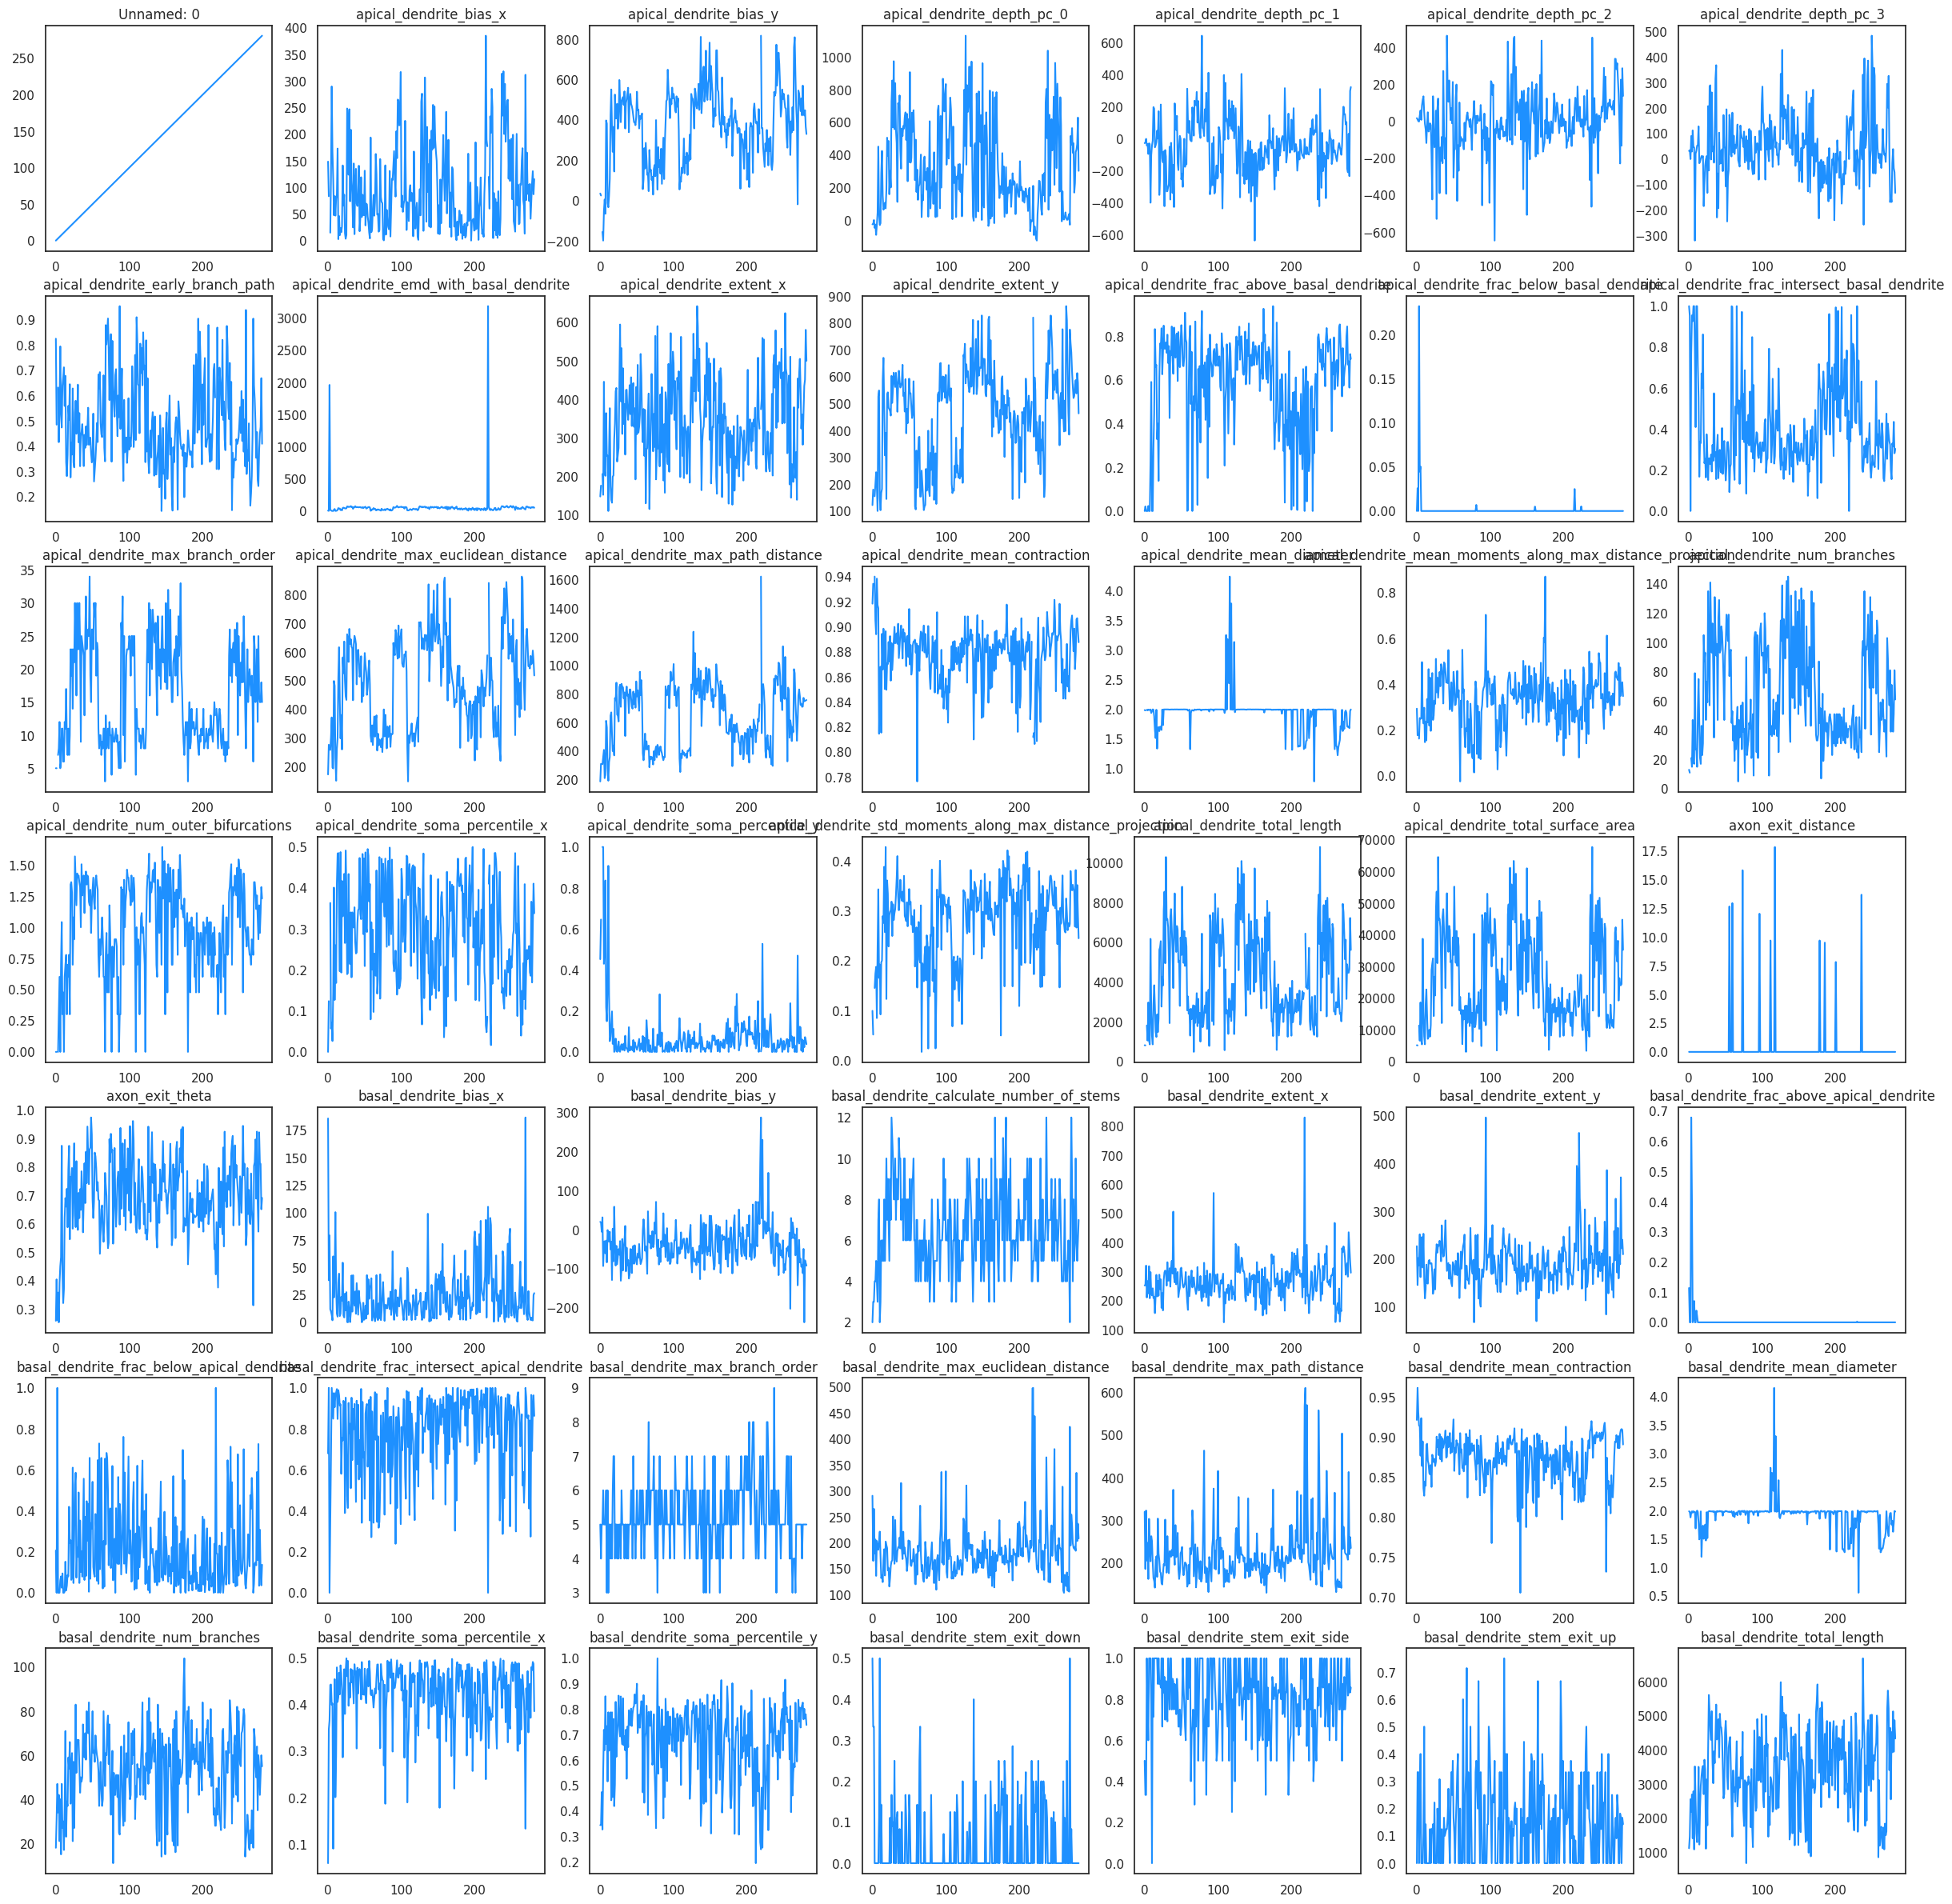

In [15]:
fig, axs = plt.subplots(7,7, figsize=(30, 30))
for ax, feature in zip(axs.flatten(), [i for i in fmost_mf.columns if i!="specimen_id"]):
    ax.plot(fmost_mf[feature], color='dodgerblue')
    ax.set_title(feature)

### Reliable features to keep:

In [16]:
m_features = {"exc": ["specimen_id",
                      "apical_dendrite_max_euclidean_distance",
                      "apical_dendrite_bias_y",
                      "apical_dendrite_extent_y",
                      "apical_dendrite_soma_percentile_y",
                      "apical_dendrite_emd_with_basal_dendrite",
                      "apical_dendrite_frac_below_basal_dendrite",
                      "basal_dendrite_frac_above_apical_dendrite",
                      "apical_dendrite_depth_pc_0",
                      "apical_dendrite_total_length",
                      "basal_dendrite_bias_y",
                      "apical_dendrite_frac_above_basal_dendrite",
                      "basal_dendrite_soma_percentile_y",
                      "basal_dendrite_max_euclidean_distance",
                      "apical_dendrite_frac_intersect_basal_dendrite",
                      "basal_dendrite_extent_y",
                      "apical_dendrite_depth_pc_1",
                      "apical_dendrite_num_branches",
                      "apical_dendrite_extent_x",
                      "basal_dendrite_extent_x",
                      "basal_dendrite_total_length"],
                      
              "inh": ["specimen_id",
                      "basal_dendrite_max_euclidean_distance",
                      "basal_dendrite_bias_y",
                      "basal_dendrite_extent_y",
                      "basal_dendrite_soma_percentile_y",
                      "axon_emd_with_basal_dendrite",
                      "basal_dendrite_frac_below_axon",
                      "basal_dendrite_frac_above_axon",
                      "basal_dendrite_total_length",
                      "basal_dendrite_frac_intersect_axon",
                      "basal_dendrite_num_branches",
                      "basal_dendrite_extent_x"]}

### Keep locked cells and reliable features from ivscc exc/inh and fmost data

In [17]:
# Keep locked cells and reliable features from ivscc exc/inh and fmost data
ivscc_exc['specimen_id'] = ivscc_exc['specimen_id'].astype(str)
ivscc_inh['specimen_id'] = ivscc_inh['specimen_id'].astype(str)
fmost_mf['specimen_id'] = fmost_mf['specimen_id'].astype(str)

ivscc_exc = ivscc_exc[ivscc_exc['specimen_id'].isin(ids['specimen_id'].to_list())]
ivscc_inh = ivscc_inh[ivscc_inh['specimen_id'].isin(ids['specimen_id'].to_list())]
fmost_mf = fmost_mf[fmost_mf['specimen_id'].isin(ids['specimen_id'].to_list())]

fmost_mf = fmost_mf[m_features['exc']]
ivscc_exc = ivscc_exc[m_features['exc']]
ivscc_inh = ivscc_inh[m_features['inh']]

### concat fmost, ivscc_inh and ivscc_exc features into a dataframe

In [18]:
data_frames = [ivscc_exc, fmost_mf, ivscc_inh]
m_features = reduce(lambda left, right: pd.merge(left, right, how='outer'), data_frames)
m_features['specimen_id'] = m_features['specimen_id'].astype(str)


...................................................
Zscoring mfeatures features
Removing extreme mfeatures values (within 6 std)


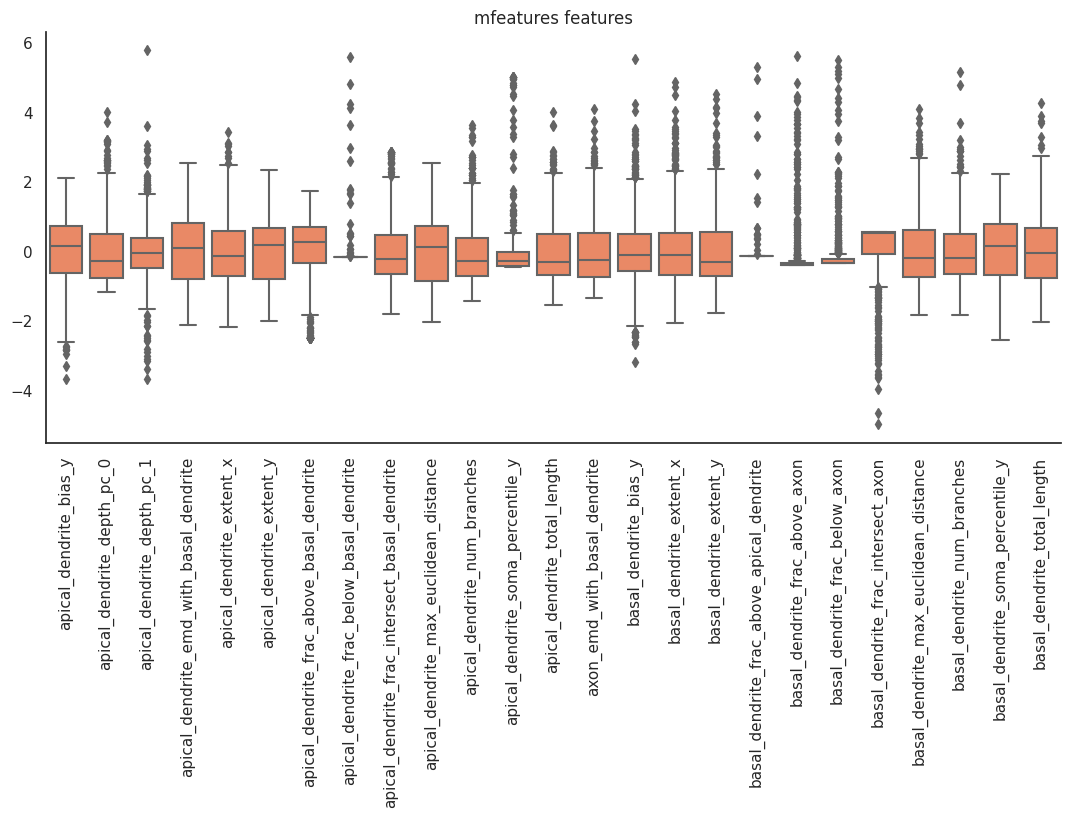

In [19]:
print("...................................................")
print("Zscoring mfeatures features")
subset_m_features = m_features[[c for c in m_features.columns if c != "specimen_id"]]
m_features_norm = (subset_m_features - subset_m_features.mean(axis=0)) / subset_m_features.std(axis=0)

print("Removing extreme mfeatures values (within 6 std)")
scaling_thr = m_features_norm.std(axis=0, skipna=True, numeric_only=True) * 6
m_features_norm = m_features_norm.reset_index()
df1 = pd.melt(m_features_norm, id_vars=['index'], value_vars=[c for c in m_features_norm if c != "index"])
df2 = pd.DataFrame(scaling_thr).reset_index().rename(columns={"index": 'variable', 0:"thr_std"})
df3 = df1.merge(df2, on="variable")
df3['new_value'] = np.where((df3['value'] < df3['thr_std']) & (df3['value'] > -1 * df3['thr_std'])
                        , df3['value'], np.nan)
m_features_norm = df3.pivot(index='index', columns="variable", values="new_value")
m_features_norm['specimen_id'] = m_features['specimen_id'].astype(str)

df = m_features_norm.melt(value_vars=m_features_norm[[c for c in m_features_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title': 'mfeatures features', 'xlabel': '', 'ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()


### Merge scaled pcs with m features

In [20]:
print("Scaled PCs size:", Scaled_PCs.shape)
print("...................................................")
print("adding soma depth and other m features to M data")
m_cells = ~np.isnan(soma_depth)
m_cells = [id for i, id in enumerate(arbor_ids) if m_cells[i]]

sd = pd.DataFrame({"specimen_id": m_cells, "soma_depth": soma_depth[~np.isnan(soma_depth)]})

data_frames = [Scaled_PCs, sd, m_features_norm]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='inner'), data_frames)
df_merged = df_merged.merge(pd.DataFrame(specimen_ids, columns=["specimen_id"]), on="specimen_id", how='right')

Scaled PCs size: (2163, 104)
...................................................
adding soma depth and other m features to M data


In [21]:
df_merged

ax_0  ax_1  ax_2  ax_3  ax_4  ax_5  ax_6  ax_7  ax_8  ax_9  ...  \
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
8638   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
8639   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
8640   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
8641   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
8642   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

      basal_dendrite_extent_x  basal_dendrite_extent_y  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                         NaN                      NaN   
4                         NaN                      NaN   
...                       ...                      ...   
8638                      NaN                      NaN   
8639                      NaN                      NaN   
8640                 2.620229                 1.306063   
8641                      NaN                      NaN   
8642                -0.514934                -0.973517   

     basal_dendrite_frac_above_apical_dendrite  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   
...                                        ...   
8638                                       NaN   
8639                                       NaN   
8640                                 -0.155768   
8641                                       NaN   
8642                                 -0.155768   

      basal_dendrite_frac_above_axon  basal_dendrite_frac_below_axon  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                NaN                             NaN   
3                                NaN                             NaN   
4                                NaN                             NaN   
...                              ...                             ...   
8638                             NaN                             NaN   
8639                             NaN                             NaN   
8640                             NaN                             NaN   
8641                             NaN                             NaN   
8642                             NaN                             NaN   

      basal_dendrite_frac_intersect_axon  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
8638                                 NaN   
8639                                 NaN   
8640                                 NaN   
8641                                 NaN   
8642                                 NaN   

      basal_dendrite_max_euclidean_distance  basal_dendrite_num_branches  \
0                                       NaN                          NaN   
1                                       NaN                          NaN   
2                                       NaN                          NaN   
3                                       NaN                          NaN   
4                                       NaN              

In [22]:
# Make sure the order is the same as the locked id spec_ids
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()

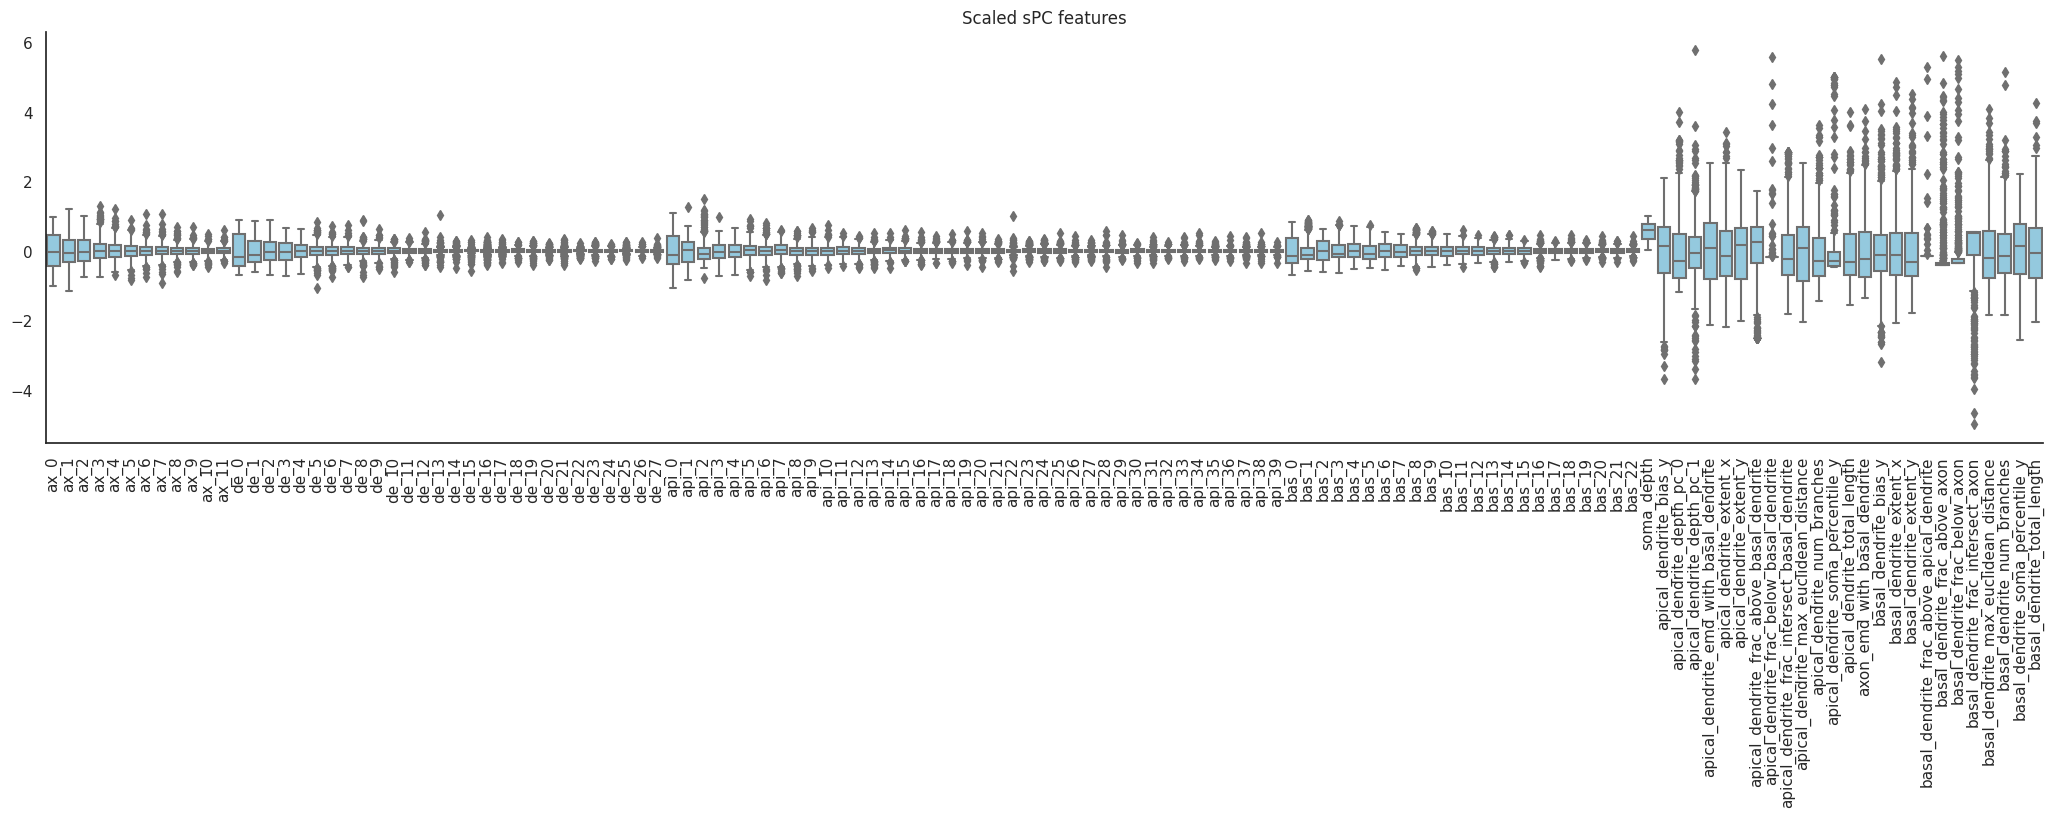

Size of Merged PCs features: (8643, 130)
Done


In [23]:
f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged PCs features:", df_merged.shape)
print("Done")